Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

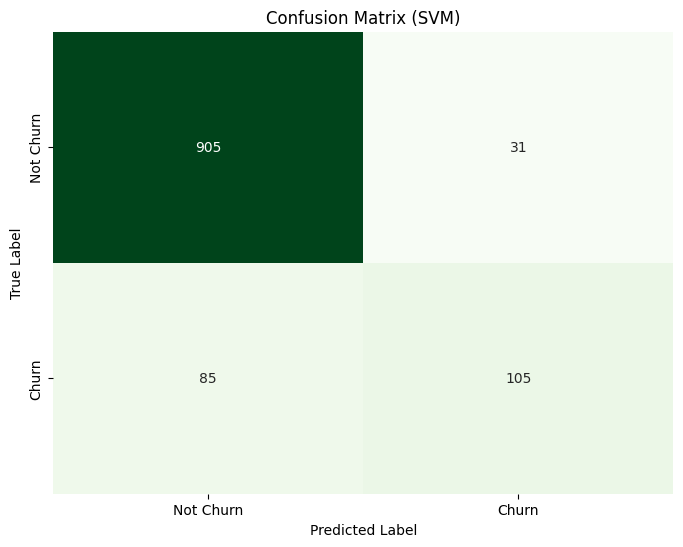


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       936
           1       0.77      0.55      0.64       190

    accuracy                           0.90      1126
   macro avg       0.84      0.76      0.79      1126
weighted avg       0.89      0.90      0.89      1126


Feature Importance (Coefficients from Linear SVM):
                                  Feature  Coefficient
26                PreferedOrderCat_Others     1.508637
0                                  Tenure    -1.153211
23    PreferedOrderCat_Laptop & Accessory    -0.811647
22               PreferedOrderCat_Grocery     0.657396
7                                Complain     0.578215
19          PreferredPaymentMode_E wallet     0.467379
28                   MaritalStatus_Single     0.463689
14             PreferredLoginDevice_Phone    -0.406465
16  PreferredPaymentMode_Cash on Delivery     0.387609
6                         NumberOfAddress     0

/var/folders/kw/rtpfp9xx5vj8h1n_95hjltnm0000gn/T/ipykernel_27336/417035174.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette="vlag")


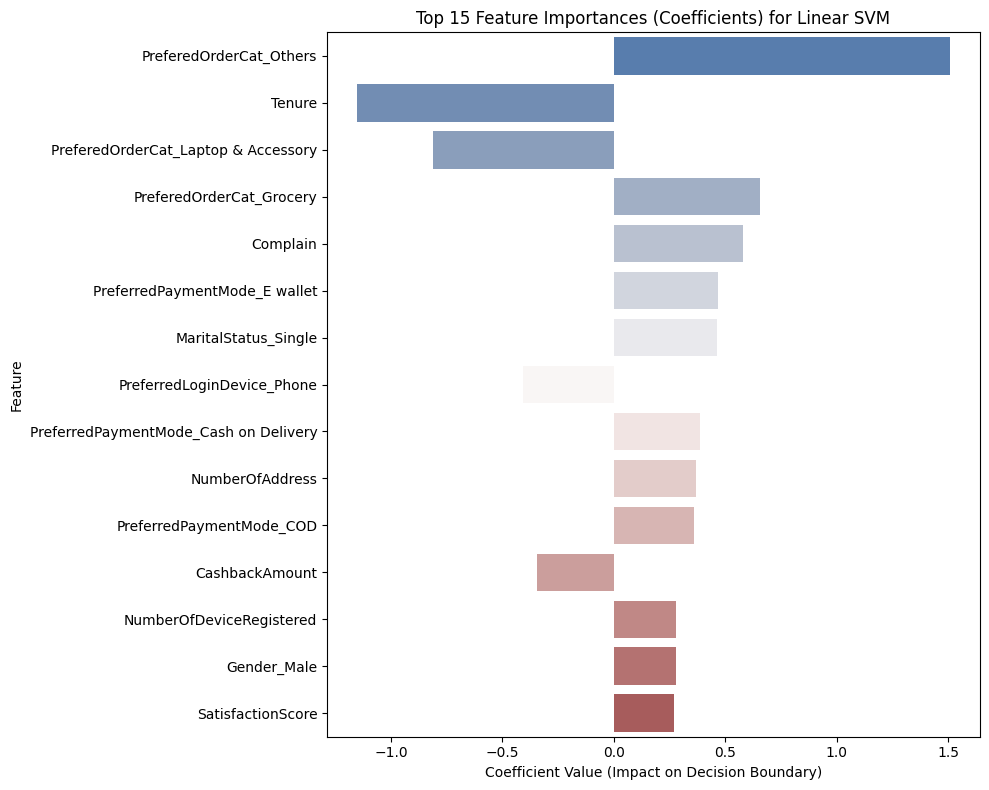

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    # Exit or raise error if file not found, to prevent further cells from running with an undefined df
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError if user runs all cells

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())

# Cell 3: Initial Data Exploration & Preprocessing (if dataset loaded)
if not df.empty:
    # Display column names to identify the target variable and features
    print("\nColumn Names:")
    print(df.columns)

    # Assuming 'Churn' is the target variable. Verify this based on your dataset.
    target_column = 'Churn'

    if target_column not in df.columns:
        print(f"\nError: Target column '{target_column}' not found in the dataset.")
        print("Please verify the target column name. Common names could be 'Exited', 'Target', etc.")
    else:
        print(f"\nTarget variable: '{target_column}'")
        print(df[target_column].value_counts(normalize=True))

        # Drop CustomerID if it exists
        if 'CustomerID' in df.columns:
            df = df.drop('CustomerID', axis=1)
            print("\nDropped 'CustomerID' column.")

        # Handle missing values (example: fill with mode for categorical and median for numerical)
        print("\nMissing values before handling:")
        print(df.isnull().sum())

        for column in df.select_dtypes(include=['object']).columns:
            df[column] = df[column].fillna(df[column].mode()[0])

        for column in df.select_dtypes(include=[np.number]).columns:
            if column != target_column: # Don't impute the target variable
                 df[column] = df[column].fillna(df[column].median())

        print("\nMissing values after handling:")
        print(df.isnull().sum())

        # Identify categorical and numerical features
        features = [col for col in df.columns if col != target_column]
        categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()
        numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

        print("\nCategorical Features:", categorical_features)
        print("Numerical Features:", numerical_features)

# Cell 4: Define Preprocessing Steps (if dataset loaded and processed)
if not df.empty and target_column in df.columns:
    # Create preprocessing pipelines for numerical and categorical features
    # Scaling is crucial for SVMs
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)

# Cell 5: Create and Train the Support Vector Machine (SVM) Model (if X_train, y_train exist)
if 'X_train' in locals() and 'y_train' in locals():
    # Create the SVM pipeline
    # We use kernel='linear' to be able to easily inspect coefficients for feature importance.
    # For potentially better performance (but harder to interpret coefficients directly),
    # you could try kernel='rbf' (default) and tune C and gamma.
    # probability=True is needed for roc_auc_score but slows down training.
    svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', SVC(kernel='linear', probability=True, random_state=42))])

    print("\nTraining the SVM model...")
    svm_pipeline.fit(X_train, y_train)
    print("Model training complete.")

# Cell 6: Make Predictions and Evaluate the Model (if model is trained)
if 'svm_pipeline' in locals() and 'X_test' in locals():
    # Make predictions
    y_pred = svm_pipeline.predict(X_test)
    y_pred_proba = svm_pipeline.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Evaluation (SVM):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, # Changed cmap for visual distinction
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (SVM)')
    plt.show()

    print("\nClassification Report:")
    print(class_report)

# Cell 7: Feature Importance (Coefficients for Linear SVM) (if model is trained)
if 'svm_pipeline' in locals() and svm_pipeline.named_steps['classifier'].kernel == 'linear':
    try:
        # Get feature names after one-hot encoding
        ohe_feature_names = svm_pipeline.named_steps['preprocessor'] \
                                        .named_transformers_['cat'] \
                                        .get_feature_names_out(categorical_features)
        
        all_feature_names = numerical_features + list(ohe_feature_names)

        # Get coefficients from the linear SVM model
        # For SVC with linear kernel, coefficients are in .coef_[0]
        coefficients = svm_pipeline.named_steps['classifier'].coef_[0]

        feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
        # For SVM, the magnitude of coefficients is important.
        # We can sort by absolute value to see impact, or by value to see direction.
        feature_importance_df['Absolute Coefficient'] = np.abs(feature_importance_df['Coefficient'])
        feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)


        print("\nFeature Importance (Coefficients from Linear SVM):")
        print(feature_importance_df[['Feature', 'Coefficient']].head(15))

        # Plot feature importance (top 15 by absolute coefficient value)
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette="vlag")
        plt.title('Top 15 Feature Importances (Coefficients) for Linear SVM')
        plt.xlabel('Coefficient Value (Impact on Decision Boundary)')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nCould not display feature importance for SVM: {e}")
        print("This is typically available for linear kernels.")
elif 'svm_pipeline' in locals():
    print("\nFeature importance via coefficients is directly available for SVM with a linear kernel.")
    print("For non-linear kernels (e.g., 'rbf'), other methods like permutation importance are used.")